In [1]:
# simple conv 
import torch
import torch.nn.functional as F

image = torch.ones(6,6)
print("Input image shape", image.shape)

#pytorch expects the input to conv2D as 4d tensor
image = image.unsqueeze(dim=0)
print("After adding a dimension", image.shape)
image = image.unsqueeze(dim=0)
print("After adding another dimension", image.shape)
print("4d image", image)
kernel = torch.ones(3,3)
print("Kernel", kernel)
kernel = kernel.unsqueeze(dim=0)
kernel = kernel.unsqueeze(dim=0) # even the kernel must be a 4d tensor
outimage = F.conv2d(image, kernel, stride=1, padding=0)
print("1st convolution", outimage)
outimage = F.conv2d(outimage, kernel, stride=1, padding=0)
print("2nd convolution", outimage)
# this will give error as the outimage is smaller than the kernel
# outimage = F.conv2d(outimage, kernel, stride=1, padding=0)
# print("3rd convolution", outimage)

Input image shape torch.Size([6, 6])
After adding a dimension torch.Size([1, 6, 6])
After adding another dimension torch.Size([1, 1, 6, 6])
4d image tensor([[[[1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1.]]]])
Kernel tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
1st convolution tensor([[[[9., 9., 9., 9.],
          [9., 9., 9., 9.],
          [9., 9., 9., 9.],
          [9., 9., 9., 9.]]]])
2nd convolution tensor([[[[81., 81.],
          [81., 81.]]]])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

image = torch.ones(1, 1, 6, 6)  
print("Input image shape:", image.shape)

# Create a Conv2D layer with out_channels=3 and in_channels=1
conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0, bias=False)

output = conv_layer(image)
print("Output shape after Conv2d:", output.shape)

kernel = torch.ones(3, 1, 3, 3) # note the shape
print("Kernel shape:", kernel.shape)

output = F.conv2d(image, kernel, stride=1, padding=0)
print("Output shape after functional conv2d:", output.shape)


Input image shape: torch.Size([1, 1, 6, 6])
Output shape after Conv2d: torch.Size([1, 3, 4, 4])
Kernel shape: torch.Size([3, 1, 3, 3])
Output shape after functional conv2d: torch.Size([1, 3, 4, 4])


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 22 * 22, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = ImageClassifier().to(device)
optimizer = Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):  
    classifier.train()  
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  
        outputs = classifier(images)  
        loss = loss_fn(outputs, labels)  
        loss.backward()  
        optimizer.step()  

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

classifier.eval() 
test_dataset = datasets.MNIST(root="data", download=True, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy()) 

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

total_params = sum(p.numel() for p in classifier.parameters() if p.requires_grad)
print(f"Total number of learnable parameters: {total_params}")


100.0%
100.0%
100.0%
100.0%


Epoch: 0, Loss: 0.07549283653497696
Epoch: 1, Loss: 0.0159999318420887
Epoch: 2, Loss: 0.04333362728357315
Epoch: 3, Loss: 0.00015264468675013632
Epoch: 4, Loss: 6.982828926993534e-05
Epoch: 5, Loss: 3.9262784412130713e-05
Epoch: 6, Loss: 0.0010959142819046974
Epoch: 7, Loss: 2.112214815497282e-06
Epoch: 8, Loss: 1.3322862287168391e-05
Epoch: 9, Loss: 6.519220505651901e-07
Confusion Matrix:
[[ 976    0    1    0    0    0    1    1    1    0]
 [   0 1130    0    2    0    0    2    1    0    0]
 [   0    1 1016    1    3    0    3    7    1    0]
 [   0    0    2 1003    0    5    0    0    0    0]
 [   0    0    0    0  969    0    5    0    1    7]
 [   1    0    1    7    0  880    3    0    0    0]
 [   4    2    0    1    2    4  944    0    1    0]
 [   0    4    5    1    1    1    0 1014    1    1]
 [   4    1    1    6    0    1    4    1  956    0]
 [   2    1    0    2    2    5    0    3   10  984]]
Total number of learnable parameters: 365514


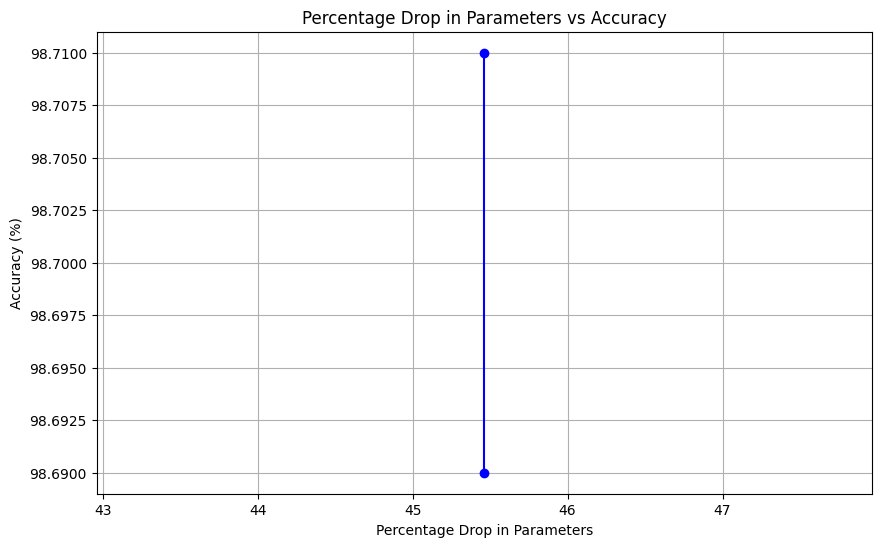

In [4]:

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="data", download=True, train=True, transform=transform)
test_dataset = datasets.MNIST(root="data", download=True, train=False, transform=transform)

class ReducedImageClassifier(nn.Module):
    def __init__(self):
        super(ReducedImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),   
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3), 
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), 
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 22 * 22, 10) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5
learning_rate = 0.001

def train_and_evaluate(model):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = loss_fn(outputs, labels)  
            loss.backward()  
            optimizer.step()  
    
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    return accuracy

parameter_counts = []
accuracies = []

for _ in [16, 32]: 
    model = ReducedImageClassifier()
    params = count_parameters(model)
    accuracy = train_and_evaluate(model)
    
    parameter_counts.append(params)
    accuracies.append(accuracy)

initial_params = 64 * 22 * 22 * 10 # taken from the model above
percentage_drops = [(initial_params - count) / initial_params * 100 for count in parameter_counts]

plt.figure(figsize=(10, 6))
plt.plot(percentage_drops, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Percentage Drop in Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Percentage Drop in Parameters vs Accuracy')
plt.grid(True)
plt.show()
